# Capstone Project - The Battle of the Neighborhoods
### Project by Tiffany Brand
### Applied Data Science Capstone by IBM/Coursera

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction: Business Problem <a name="introduction"></a>

The goal of this project is to find potential expansion locations for stakeholders with currently successful restaurants Boston, looking to expand to Manhattan or Chicago. For the purposes of this project, our stakeholder will have a **successful restaurant in Boston's Back Bay neighborhood** and is interested in opening a restaurant in a **similar neighborhood in Chicago and Manhattan.** 

This stakeholder's trendy restaurant thrives in its current location, so they want to find a neighborhood of similar composition to Boston's Back Bay to hopefully replicate the success of their current business type. This will require looking at all types of venues located in neighborhoods of each city.

Using data science methods we will identify several potential expansion neighborhoods in Chicago and Manhattan, looking at areas of **similar venue categories** and **comparable venue density.**

## Data <a name="data"></a>

Based on the requirements of the business problem, the following types of data will be necessary:

* geographic data defining neighborhoods in Boston, Chicago, and Manhattan
* the number of venues located in neighborhoods in Boston, Chicago, and Manhattan
* category types of venues located in neighborhoods in Boston, Chicago, and Manhattan

Neighborhood boundaries for each city will be found in

* **Boston:** The Boston Neighborhoods dataset can be found here: <a href="https://data.boston.gov/dataset/boston-neighborhoods">https://data.boston.gov/dataset/boston-neighborhoods</a> - This dataset is found on the Analyze Boston website created by Boston’s GIS department. The data is a combination of zoning neighborhood boundaries, zip code boundaries, and 2010 Census tract boundaries. They state that the neighborhood boundaries are not official but can be used in a broad sense for visualization and planning. The GeoJSON version of the data will be downloaded. The following features will be extracted: Neighborhood name and the latitude and longitude data marking the boundaries of the neighborhood. From the boundaries, centroid coordinates of the neighborhoods will be calculated.

* **Chicago:** The Chicago Boundaries – Neighborhoods dataset can be found here: <a href="https://data.cityofchicago.org/Facilities-Geographic-Boundaries/Boundaries-Neighborhoods/bbvz-uum9">https://data.cityofchicago.org/Facilities-Geographic-Boundaries/Boundaries-Neighborhoods/bbvz-uum9</a> - This dataset is found on the Chicago Data Portal and was developed by the Office of Tourism to describe the approximate neighborhood names of Chicago. The GeoJSON version of the data will be downloaded. The following features will be extracted: Neighborhood name and the latitude and longitude data marking the boundaries of the neighborhood. From the boundaries, centroid coordinates of the neighborhoods will be calculated.

* **Manhattan:** The New York City neighborhoods data can be found here in a JSON file: <a href="https://cocl.us/new_york_dataset">https://cocl.us/new_york_dataset</a>  (this was the dataset used for the week 3 lab in this capstone course). The dataset is found on the NYU Spatial Dataset Repository <a href="https://geo.nyu.edu/catalog/nyu_2451_34572">https://geo.nyu.edu/catalog/nyu_2451_34572</a>. It was created as a guide to New York City’s neighborhoods. The following features will be extracted: Neighborhood name, Borough, Latitude and Longitude. Using the borough feature, the neighborhoods from Manhattan will be extracted.

The number and category of venues in each neighborhood will be found using the **Foursquare API** (<a href="https://api.foursquare.com">https://api.foursquare.com</a>). Foursquare houses a global database of 105 million places with more than 70 venue attributes and more than 900 categories. Features extracted will be Venue Name, Venue Category, Venue Latitude and Longitude. 




### Obtaining and Cleaning Neighborhood Data

For each city, we will **load the datafile** containing the geographic information defining neighborhood boundaries. From the boundary information, **centroids will be calculated** for each neighborhood to use in our venue search later. The neighborhood names and centroid coordinates will be loaded into a dataframe by city. We'll also **map each city's neighborhoods**.  After all three cities neighborhood data has been extracted, the **data from all three cities will be combined into one dataframe.**

### Import Libraries

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes 
import folium # map rendering library

!conda install -c conda-forge shapely --yes
from shapely.geometry import Polygon

print('Libraries imported.')

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.11
  latest version: 4.7.11

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    geopy-1.20.0               |             py_0          57 KB  conda-forge
    geographiclib-1.49         |             py_0          32 KB  conda-forge
    ------------------------------------------------------------
                                           Total:          90 KB

The following NEW packages will be INSTALLED:

    geographiclib: 1.49-py_0   conda-forge
    geopy:         1.20.0-py_0 conda-forge


geopy-1.20.0         | 57 KB     | ##################################### | 100% 
geographiclib-1.49   | 

### Load and Clean Boston, MA Neighborhood Data

Here we're loading in the datafile from the Analyze Boston website.

In [2]:
!wget -q -O 'boston_data.json' http://bostonopendata-boston.opendata.arcgis.com/datasets/3525b0ee6e6b427f9aab5d0a1d0a1a28_0.geojson
print('Data downloaded!')    

Data downloaded!


In [3]:
with open('boston_data.json') as json_data:
    boston_data = json.load(json_data)

Extracting the features of the data which contains the neighborhood name and the shape coordinates marking the boundaries of the neighborhoods.

In [4]:
neighborhoods_data = boston_data['features']

Setting up the dataframe to contain the Boston neighborhoods with their centroid coordinates.

In [5]:
# define the dataframe columns
column_names = ['Location', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
bos_neighborhoods = pd.DataFrame(columns=column_names)

In [6]:
bos_neighborhoods

,Location,Neighborhood,Latitude,Longitude


Calculating the centroids of each neighborhood and loading all the data into the Boston dataframe

In [7]:
for data in neighborhoods_data:
    neighborhood_name = data['properties']['Name']
    poly_type = data['geometry']['type']
    if poly_type == "MultiPolygon":
        neighborhood_coords = data['geometry']['coordinates'][0][0]
    else:
        neighborhood_coords = data['geometry']['coordinates'][0]
    neighborhood_polygon = Polygon(neighborhood_coords)
    neighborhood_lat = neighborhood_polygon.centroid.coords[0][1]
    neighborhood_lon = neighborhood_polygon.centroid.coords[0][0]
    bos_neighborhoods = bos_neighborhoods.append({'Location': "Boston", 'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

In [8]:
bos_neighborhoods

,Location,Neighborhood,Latitude,Longitude
0,Boston,Roslindale,42.282524,-71.126663
1,Boston,Jamaica Plain,42.307770,-71.115097
2,Boston,Mission Hill,42.331741,-71.102607
3,Boston,Longwood,42.338609,-71.105103
4,Boston,Bay Village,42.349103,-71.069032
5,Boston,Leather District,42.350983,-71.057828
6,Boston,Chinatown,42.349027,-71.061662
7,Boston,North End,42.365465,-71.053858
8,Boston,Roxbury,42.318519,-71.086643
9,Boston,South End,42.341350,-71.071369


Creating a map to visualize the Boston neighborhoods

In [9]:
address = 'Boston, MA'

geolocator = Nominatim(user_agent="boston_explorer")
location = geolocator.geocode(address)
boslatitude = location.latitude
boslongitude = location.longitude
print('The geograpical coordinate of Boston are {}, {}.'.format(boslatitude, boslongitude))

The geograpical coordinate of Boston are 42.3602534, -71.0582912.


In [10]:
# create map of Boston using latitude and longitude values
map_boston = folium.Map(location=[boslatitude, boslongitude], zoom_start=12)

# add markers to map
for lat, lng, neighborhood in zip(bos_neighborhoods['Latitude'], bos_neighborhoods['Longitude'], bos_neighborhoods['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_boston)  
    
map_boston

### Load and Clean Chicago, IL Data

Here we're loading in the datafile from the city of Chicago website.

In [11]:
!wget -q -O 'chicago_data.json' https://data.cityofchicago.org/api/geospatial/bbvz-uum9?method=export&format=GeoJSON
print('Data downloaded!')  

Data downloaded!


In [12]:
with open('chicago_data.json') as json_data:
    chicago_data = json.load(json_data)

Extracting the features of the data which contains the neighborhood name and the shape coordinates marking the boundaries of the neighborhoods.

In [13]:
chicagonb_data = chicago_data['features']

Setting up the dataframe to contain the Boston neighborhoods with their centroid coordinates.

In [14]:
# define the dataframe columns
column_names = ['Location', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
chicago_neighborhoods = pd.DataFrame(columns=column_names)

In [15]:
chicago_neighborhoods

,Location,Neighborhood,Latitude,Longitude


Calculating the centroids of each neighborhood and loading all the data into the Chicago dataframe

In [16]:
for data in chicagonb_data:
    neighborhood_name = data['properties']['pri_neigh']
    poly_type = data['geometry']['type']
    if poly_type == "MultiPolygon":
        neighborhood_coords = data['geometry']['coordinates'][0][0]
    else:
        neighborhood_coords = data['geometry']['coordinates'][0]
    neighborhood_polygon = Polygon(neighborhood_coords)
    neighborhood_lat = neighborhood_polygon.centroid.coords[0][1]
    neighborhood_lon = neighborhood_polygon.centroid.coords[0][0]
    chicago_neighborhoods = chicago_neighborhoods.append({'Location': "Chicago", 'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

In [17]:
chicago_neighborhoods

,Location,Neighborhood,Latitude,Longitude
0,Chicago,Grand Boulevard,41.812949,-87.617860
1,Chicago,Printers Row,41.870981,-87.629035
2,Chicago,United Center,41.881965,-87.679136
3,Chicago,Sheffield & DePaul,41.927188,-87.653670
4,Chicago,Humboldt Park,41.900889,-87.716507
5,Chicago,Garfield Park,41.878786,-87.715659
6,Chicago,North Lawndale,41.860190,-87.717219
7,Chicago,Little Village,41.839087,-87.714002
8,Chicago,Armour Square,41.836091,-87.633222
9,Chicago,Avalon Park,41.744200,-87.586349


Creating a map to visualize the Chicago neighborhoods

In [18]:
address = 'Chicago, IL'

geolocator = Nominatim(user_agent="chicago_explorer")
location = geolocator.geocode(address)
chilatitude = location.latitude
chilongitude = location.longitude
print('The geograpical coordinates of Chicago are {}, {}.'.format(chilatitude, chilongitude))

The geograpical coordinates of Chicago are 41.8755616, -87.6244212.


In [19]:
# create map of Chicago using latitude and longitude values
map_chicago = folium.Map(location=[chilatitude, chilongitude], zoom_start=10)

# add markers to map
for lat, lng, neighborhood in zip(chicago_neighborhoods['Latitude'], chicago_neighborhoods['Longitude'], chicago_neighborhoods['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_chicago)  
    
map_chicago

### Load and Clean Manhattan, NYC Data

Here we're loading in the datafile that was prepared for our week 3 class and is located on the Cognitive Class website. The original source of the data was from the NYU Spatial Dataset Repository.

In [20]:
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
print('Data downloaded!')

Data downloaded!


In [21]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

Extracting the features of the data which contains the borough name, the neighborhood name and the centroid coordinates of the neighborhoods.

In [22]:
neighborhoods_data = newyork_data['features']

Loading all the data into the New york City dataframe

In [23]:
# define the dataframe columns
column_names = ['Location', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

In [24]:
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Location': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

In [25]:
neighborhoods.head()

,Location,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


Extracting just the neighborhoods in the borough of Manhattan

In [26]:
manhattan_data = neighborhoods[neighborhoods['Location'] == 'Manhattan'].reset_index(drop=True)
manhattan_data.head()

,Location,Neighborhood,Latitude,Longitude
0,Manhattan,Marble Hill,40.876551,-73.910660
1,Manhattan,Chinatown,40.715618,-73.994279
2,Manhattan,Washington Heights,40.851903,-73.936900
3,Manhattan,Inwood,40.867684,-73.921210
4,Manhattan,Hamilton Heights,40.823604,-73.949688


Creating a map to visualize the Manhattan neighborhoods

In [27]:
address = 'Manhattan, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
manlatitude = location.latitude
manlongitude = location.longitude
print('The geograpical coordinates of Manhattan are {}, {}.'.format(manlatitude, manlongitude))

The geograpical coordinates of Manhattan are 40.7900869, -73.9598295.


In [28]:
# create map of Manhattan using latitude and longitude values
map_manhattan = folium.Map(location=[manlatitude, manlongitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(manhattan_data['Latitude'], manhattan_data['Longitude'], manhattan_data['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_manhattan)  
    
map_manhattan

Here we are joining the data from all three cities into one dataframe. An **additional feature,  Loc_Neigh, is added** to use as a key since the cities have **some neighborhoods with the same name**.

In [29]:
cities_data =  pd.concat([bos_neighborhoods, manhattan_data, chicago_neighborhoods], ignore_index=True)

In [65]:
cities_data.shape

(164, 5)

In [30]:
cities_data['Loc_Neigh']=cities_data['Location'] + '_' + cities_data['Neighborhood']
cities_data

,Location,Neighborhood,Latitude,Longitude,Loc_Neigh
0,Boston,Roslindale,42.282524,-71.126663,Boston_Roslindale
1,Boston,Jamaica Plain,42.307770,-71.115097,Boston_Jamaica Plain
2,Boston,Mission Hill,42.331741,-71.102607,Boston_Mission Hill
3,Boston,Longwood,42.338609,-71.105103,Boston_Longwood
4,Boston,Bay Village,42.349103,-71.069032,Boston_Bay Village
5,Boston,Leather District,42.350983,-71.057828,Boston_Leather District
6,Boston,Chinatown,42.349027,-71.061662,Boston_Chinatown
7,Boston,North End,42.365465,-71.053858,Boston_North End
8,Boston,Roxbury,42.318519,-71.086643,Boston_Roxbury
9,Boston,South End,42.341350,-71.071369,Boston_South End


### Foursquare

Now that we have our neighborhoods in the three cities defined, let's extract venue data for each neighborhood using the Foursquare API. We need to extract all venues which will define the composition of a neighborhood. We'll define nearby venues as the first 100 venues within a radius of 500 meters of the neighborhood centroid.

In [31]:
CLIENT_ID = 'M0IXLRJGGEKNEFHA3YOEP5PLJ53PLZD2QJPMXPYY03UXANXK' # your Foursquare ID
CLIENT_SECRET = 'WVCFNBRV0WE2VHTQQMSNTQL4BEXCAODNQVDOTLPDPUTE5BDI' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100
radius = 500

print('Your credentials:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentials:
CLIENT_ID: M0IXLRJGGEKNEFHA3YOEP5PLJ53PLZD2QJPMXPYY03UXANXK
CLIENT_SECRET:WVCFNBRV0WE2VHTQQMSNTQL4BEXCAODNQVDOTLPDPUTE5BDI


## Define functions to get venues from Foursquare and extract the categories

In [32]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [33]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Loc_Neigh', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

## Get nearby venues for the city data

In [34]:
cities_venues = getNearbyVenues(names=cities_data['Loc_Neigh'],
                                   latitudes=cities_data['Latitude'],
                                   longitudes=cities_data['Longitude'] 
                                  )

Boston_Roslindale
Boston_Jamaica Plain
Boston_Mission Hill
Boston_Longwood
Boston_Bay Village
Boston_Leather District
Boston_Chinatown
Boston_North End
Boston_Roxbury
Boston_South End
Boston_Back Bay
Boston_East Boston
Boston_Charlestown
Boston_West End
Boston_Beacon Hill
Boston_Downtown
Boston_Fenway
Boston_Brighton
Boston_West Roxbury
Boston_Hyde Park
Boston_Mattapan
Boston_Dorchester
Boston_South Boston Waterfront
Boston_South Boston
Boston_Allston
Boston_Harbor Islands
Manhattan_Marble Hill
Manhattan_Chinatown
Manhattan_Washington Heights
Manhattan_Inwood
Manhattan_Hamilton Heights
Manhattan_Manhattanville
Manhattan_Central Harlem
Manhattan_East Harlem
Manhattan_Upper East Side
Manhattan_Yorkville
Manhattan_Lenox Hill
Manhattan_Roosevelt Island
Manhattan_Upper West Side
Manhattan_Lincoln Square
Manhattan_Clinton
Manhattan_Midtown
Manhattan_Murray Hill
Manhattan_Chelsea
Manhattan_Greenwich Village
Manhattan_East Village
Manhattan_Lower East Side
Manhattan_Tribeca
Manhattan_Little It

In [35]:
print(cities_venues.shape)
cities_venues.head()

(7328, 7)


,Loc_Neigh,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Boston_Roslindale,42.282524,-71.126663,Fornax Bread Company,42.286171,-71.129760,Bakery
1,Boston_Roslindale,42.282524,-71.126663,Roslindale Square,42.285815,-71.129304,Plaza
2,Boston_Roslindale,42.282524,-71.126663,Roslindale Village Farmers Market,42.286534,-71.128509,Farmers Market
3,Boston_Roslindale,42.282524,-71.126663,Effie's Kitchen,42.285899,-71.128741,Greek Restaurant
4,Boston_Roslindale,42.282524,-71.126663,BK's Pub,42.285167,-71.129425,Bar


Now we have venues near to the centroid of each neighborhood. Let's look at how many venues per neighborhood were found in Foursquare up to our limit which was 100 venues.

In [36]:
cities_venues.groupby('Loc_Neigh').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Loc_Neigh,,,,,,
Boston_Allston,9,9,9,9,9,9
Boston_Back Bay,100,100,100,100,100,100
Boston_Bay Village,87,87,87,87,87,87
Boston_Beacon Hill,56,56,56,56,56,56
Boston_Brighton,47,47,47,47,47,47
Boston_Charlestown,28,28,28,28,28,28
Boston_Chinatown,90,90,90,90,90,90
Boston_Dorchester,30,30,30,30,30,30
Boston_Downtown,100,100,100,100,100,100


Some neighborhoods, including our stakeholder's current restaurant location of Boston's Back Bay, returned the maximum 100 venues. Other neighborhoods have many fewer venues. We will keep this in mind as we move forward with our analysis.

## Methodology <a name="methodology"></a>

In this project we are looking for neighborhoods that are similar to the stakeholder's current restaurant neighborhood of Boston's Back Bay. We will be looking for similarities based on the numbers and categories of venues in each neighborhood, as well as the density of venues in each neighborhood. 

In our first step, we have gathered venues nearby each neighborhood up to a maximum of 100 venues. 

In our second step, we will narrow down the list of neighborhoods to consider, by looking at only neighborhoods which have a similar density of venues to Boston's Back Bay.

In our third step, we will create clusters using k-means clustering based on the common types of venues in each neighborhood. The results will let us recommend potential neighborhoods of similar composition for our stakeholder to consider for his restaurant expansion.

## Analysis <a name="analysis"></a>

### Narrowing down the neighborhoods to consider based on similarity of venue density to our stakeholder's current restaurant

For the purposes of this capstone project, our client's current restaurant is located in Boston's Back Bay neighborhood, which is dense with venues according to Foursquare, returning the maximum number of venues based on our limit. For our clustering analysis, we want to only consider neighborhoods in other cities that are dense with venues. We will choose to filter neighborhoods returning greater than 50 venues within the 500 yard radius.

In [37]:
cities_venues_dense = cities_venues.groupby("Loc_Neigh").filter(lambda x: len(x) > 50)

In [38]:
cities_venues_dense.groupby('Loc_Neigh').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Loc_Neigh,,,,,,
Boston_Back Bay,100,100,100,100,100,100
Boston_Bay Village,87,87,87,87,87,87
Boston_Beacon Hill,56,56,56,56,56,56
Boston_Chinatown,90,90,90,90,90,90
Boston_Downtown,100,100,100,100,100,100
Boston_Fenway,100,100,100,100,100,100
Boston_Leather District,100,100,100,100,100,100
Boston_North End,100,100,100,100,100,100
Boston_South End,73,73,73,73,73,73


### Exploratory Data Analysis

Let's check to see how many unique categories are found in the remaining neighborhoods.

In [39]:
print('There are {} unique categories.'.format(len(cities_venues_dense['Venue Category'].unique())))

There are 364 unique categories.


Let's also look at how many venues of each category are in our data set.

In [41]:
cities_venues_dense.groupby('Venue Category').count()

,Loc_Neigh,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude
Venue Category,,,,,,
Accessories Store,10,10,10,10,10,10
Adult Boutique,2,2,2,2,2,2
Afghan Restaurant,1,1,1,1,1,1
African Restaurant,3,3,3,3,3,3
American Restaurant,138,138,138,138,138,138
Amphitheater,1,1,1,1,1,1
Antique Shop,6,6,6,6,6,6
Arcade,2,2,2,2,2,2
Arepa Restaurant,5,5,5,5,5,5


Let's use one hot encoding for the venue data to prepare it for further analysis

In [42]:
# one hot encoding
cities_onehot = pd.get_dummies(cities_venues_dense[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
cities_onehot['Loc_Neigh'] = cities_venues_dense['Loc_Neigh'] 

# move neighborhood column to the first column
fixed_columns = [cities_onehot.columns[-1]] + list(cities_onehot.columns[:-1])
cities_onehot = cities_onehot[fixed_columns]

cities_onehot.head()

,Loc_Neigh,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,Amphitheater,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Business Service,Butcher,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Cemetery,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Bookstore,College Theater,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Convenience Store,Cooking School,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Entertainment Service,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Financial or Legal Service,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General College & University,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Halal Restaurant,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,Herbs & Spices Store,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hockey Arena,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Indoor Play Area,Insurance Office,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Knitting Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Leather Goods Store,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Multiplex,Museum,Music School,Music Store,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Newsstand,Nightclub,Non-Profit,Noodle House,North Indian Restaurant,Office,Opera House,Optical Shop,Organic Grocery,Other Repair Shop,Outdoor Sculpture,Outdoors & Recreation,Paella Restaurant,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Café,Pet Service,Pet Store,Pharmacy,Photography Studio,Piano Bar,Pie Shop,Pilates Studio,Pizza Place,Planetarium,Playground,Plaza,Poke Place,Pool,Pub,Public Art,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Residentia

Let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [43]:
cities_grouped = cities_onehot.groupby('Loc_Neigh').mean().reset_index()
cities_grouped

,Loc_Neigh,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,Amphitheater,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Business Service,Butcher,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Cemetery,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Bookstore,College Theater,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Convenience Store,Cooking School,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Entertainment Service,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Financial or Legal Service,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General College & University,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Halal Restaurant,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,Herbs & Spices Store,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hockey Arena,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Indoor Play Area,Insurance Office,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Knitting Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Leather Goods Store,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Multiplex,Museum,Music School,Music Store,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Newsstand,Nightclub,Non-Profit,Noodle House,North Indian Restaurant,Office,Opera House,Optical Shop,Organic Grocery,Other Repair Shop,Outdoor Sculpture,Outdoors & Recreation,Paella Restaurant,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Café,Pet Service,Pet Store,Pharmacy,Photography Studio,Piano Bar,Pie Shop,Pilates Studio,Pizza Place,Planetarium,Playground,Plaza,Poke Place,Pool,Pub,Public Art,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Residentia

In [44]:
cities_grouped.shape

(62, 365)

Now let's look at each neighborhood along with the top 5 most common venues

In [45]:
num_top_venues = 5

for hood in cities_grouped['Loc_Neigh']:
    print("----"+hood+"----")
    temp = cities_grouped[cities_grouped['Loc_Neigh'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Boston_Back Bay----
                 venue  freq
0          Coffee Shop  0.07
1  American Restaurant  0.06
2   Italian Restaurant  0.05
3   Seafood Restaurant  0.04
4       Ice Cream Shop  0.04


----Boston_Bay Village----
                venue  freq
0             Theater  0.08
1                 Spa  0.06
2               Hotel  0.06
3      Sandwich Place  0.06
4  Seafood Restaurant  0.05


----Boston_Beacon Hill----
                venue  freq
0         Pizza Place  0.09
1   French Restaurant  0.04
2        Gourmet Shop  0.04
3                Park  0.04
4  Italian Restaurant  0.04


----Boston_Chinatown----
                venue  freq
0  Chinese Restaurant  0.14
1    Asian Restaurant  0.08
2              Bakery  0.07
3    Sushi Restaurant  0.04
4             Theater  0.04


----Boston_Downtown----
                 venue  freq
0          Coffee Shop  0.08
1       Sandwich Place  0.06
2   Italian Restaurant  0.05
3        Historic Site  0.04
4  American Restaurant  0.04


----Boston_

Now let's put the top 10 venues for each neighborhood into a pandas dataframe to prepare for clustering

In [46]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [47]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Loc_Neigh']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Loc_Neigh'] = cities_grouped['Loc_Neigh']

for ind in np.arange(cities_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(cities_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Loc_Neigh,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Boston_Back Bay,Coffee Shop,American Restaurant,Italian Restaurant,Seafood Restaurant,Hotel,Ice Cream Shop,Clothing Store,Cosmetics Shop,Gym,Sporting Goods Shop
1,Boston_Bay Village,Theater,Hotel,Sandwich Place,Spa,Seafood Restaurant,American Restaurant,Performing Arts Venue,Coffee Shop,Steakhouse,Italian Restaurant
2,Boston_Beacon Hill,Pizza Place,Italian Restaurant,Gift Shop,Sandwich Place,Plaza,Playground,Park,French Restaurant,Sushi Restaurant,Gourmet Shop
3,Boston_Chinatown,Chinese Restaurant,Asian Restaurant,Bakery,Sushi Restaurant,Theater,Bubble Tea Shop,Coffee Shop,Café,Japanese Restaurant,Restaurant
4,Boston_Downtown,Coffee Shop,Sandwich Place,Italian Restaurant,American Restaurant,Historic Site,New American Restaurant,Hotel,Park,Falafel Restaurant,Salad Place


### Cluster Analysis

First let's generate an elbow curve graph to determine the best K

In [48]:
cities_grouped_clustering = cities_grouped.drop('Loc_Neigh', 1)

In [49]:
import pylab as pl
import matplotlib.pyplot as plt

In [50]:
Sum_of_squared_distances = []
K = range(1,30)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(cities_grouped_clustering)
    Sum_of_squared_distances.append(km.inertia_)

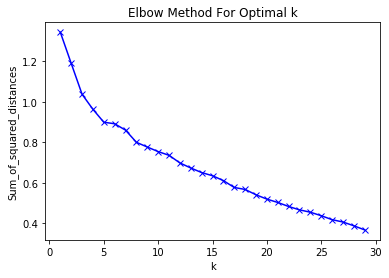

In [51]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

Based on the elbow curve, 5 clusters will be chosen

In [52]:
# set number of clusters
kclusters = 5

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(cities_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 1, 3, 0, 1, 3, 0, 2, 3, 3], dtype=int32)

Now we'll create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [53]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

cities_merged = cities_data

# merge cities_grouped with cities_data to add latitude/longitude for each neighborhood
cities_merged = cities_merged.join(neighborhoods_venues_sorted.set_index('Loc_Neigh'), on='Loc_Neigh', how='right')

cities_merged.head() # check the last columns!

,Location,Neighborhood,Latitude,Longitude,Loc_Neigh,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,Boston,Bay Village,42.349103,-71.069032,Boston_Bay Village,1,Theater,Hotel,Sandwich Place,Spa,Seafood Restaurant,American Restaurant,Performing Arts Venue,Coffee Shop,Steakhouse,Italian Restaurant
5,Boston,Leather District,42.350983,-71.057828,Boston_Leather District,0,Chinese Restaurant,Bakery,Asian Restaurant,Food Truck,Coffee Shop,Sandwich Place,Café,Sushi Restaurant,Vegetarian / Vegan Restaurant,American Restaurant
6,Boston,Chinatown,42.349027,-71.061662,Boston_Chinatown,0,Chinese Restaurant,Asian Restaurant,Bakery,Sushi Restaurant,Theater,Bubble Tea Shop,Coffee Shop,Café,Japanese Restaurant,Restaurant
7,Boston,North End,42.365465,-71.053858,Boston_North End,2,Italian Restaurant,Park,Bakery,Seafood Restaurant,Pizza Place,Wine Shop,Café,Market,Sandwich Place,Coffee Shop
9,Boston,South End,42.341350,-71.071369,Boston_South End,3,Wine Bar,American Restaurant,Italian Restaurant,Mexican Restaurant,Pizza Place,Pet Store,Park,Theater,Café,Gym / Fitness Center


In [54]:
cities_merged

,Location,Neighborhood,Latitude,Longitude,Loc_Neigh,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,Boston,Bay Village,42.349103,-71.069032,Boston_Bay Village,1,Theater,Hotel,Sandwich Place,Spa,Seafood Restaurant,American Restaurant,Performing Arts Venue,Coffee Shop,Steakhouse,Italian Restaurant
5,Boston,Leather District,42.350983,-71.057828,Boston_Leather District,0,Chinese Restaurant,Bakery,Asian Restaurant,Food Truck,Coffee Shop,Sandwich Place,Café,Sushi Restaurant,Vegetarian / Vegan Restaurant,American Restaurant
6,Boston,Chinatown,42.349027,-71.061662,Boston_Chinatown,0,Chinese Restaurant,Asian Restaurant,Bakery,Sushi Restaurant,Theater,Bubble Tea Shop,Coffee Shop,Café,Japanese Restaurant,Restaurant
7,Boston,North End,42.365465,-71.053858,Boston_North End,2,Italian Restaurant,Park,Bakery,Seafood Restaurant,Pizza Place,Wine Shop,Café,Market,Sandwich Place,Coffee Shop
9,Boston,South End,42.341350,-71.071369,Boston_South End,3,Wine Bar,American Restaurant,Italian Restaurant,Mexican Restaurant,Pizza Place,Pet Store,Park,Theater,Café,Gym / Fitness Center
10,Boston,Back Bay,42.349861,-71.080535,Boston_Back Bay,1,Coffee Shop,American Restaurant,Italian Restaurant,Seafood Restaurant,Hotel,Ice Cream Shop,Clothing Store,Cosmetics Shop,Gym,Sporting Goods Shop
13,Boston,West End,42.364548,-71.065428,Boston_West End,3,Sandwich Place,Pizza Place,Hotel,Donut Shop,American Restaurant,Bar,Café,Coffee Shop,Museum,Mexican Restaurant
14,Boston,Beacon Hill,42.357050,-71.068262,Boston_Beacon Hill,3,Pizza Place,Italian Restaurant,Gift Shop,Sandwich Place,Plaza,Playground,Park,French Restaurant,Sushi Restaurant,Gourmet Shop
15,Boston,Downtown,42.355593,-71.057651,Boston_Downtown,1,Coffee Shop,Sandwich Place,Italian Restaurant,American Restaurant,Historic Site,New American Restaurant,Hotel,Park,Falafel Restaurant,Salad Place
16,Boston,Fenway,42.344767,-71.096115,Boston_Fenway,3,Sports Bar,American Restaurant,Pizza Place,Coffee Shop,Lounge,Café,Hotel,Baseball Field,Thai Restaurant,Japanese Restaurant


Let's visualize the resulting clusters on maps


### Boston Map of Clusters

In [56]:
# create map
map_clusters = folium.Map(location=[boslatitude, boslongitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(cities_merged['Latitude'], cities_merged['Longitude'], cities_merged['Neighborhood'], cities_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Chicago Map of Clusters

In [57]:
# create map
map_clusters = folium.Map(location=[chilatitude, chilongitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(cities_merged['Latitude'], cities_merged['Longitude'], cities_merged['Neighborhood'], cities_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Manhattan Map of Clusters

In [58]:
# create map
map_clusters = folium.Map(location=[manlatitude, manlongitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(cities_merged['Latitude'], cities_merged['Longitude'], cities_merged['Neighborhood'], cities_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Let's examine the clusters more closely with their common venue types to look at the composition of the neighborhoods.

### First Cluster (0) Asian Restaurants

In [59]:
cities_merged.loc[cities_merged['Cluster Labels'] == 0, cities_merged.columns[[1] + list(range(5, cities_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,Leather District,0,Chinese Restaurant,Bakery,Asian Restaurant,Food Truck,Coffee Shop,Sandwich Place,Café,Sushi Restaurant,Vegetarian / Vegan Restaurant,American Restaurant
6,Chinatown,0,Chinese Restaurant,Asian Restaurant,Bakery,Sushi Restaurant,Theater,Bubble Tea Shop,Coffee Shop,Café,Japanese Restaurant,Restaurant
27,Chinatown,0,Chinese Restaurant,Cocktail Bar,American Restaurant,Salon / Barbershop,Vietnamese Restaurant,Spa,Bubble Tea Shop,Ice Cream Shop,Dim Sum Restaurant,Bakery
45,East Village,0,Bar,Wine Bar,Ice Cream Shop,Mexican Restaurant,Chinese Restaurant,Pizza Place,Ramen Restaurant,Coffee Shop,Cocktail Bar,Vegetarian / Vegan Restaurant
149,Bridgeport,0,Chinese Restaurant,Pharmacy,Bar,Grocery Store,Pizza Place,Mobile Phone Shop,Korean Restaurant,Wings Joint,Gift Shop,Park


### Second Cluster (1) - Mixed Variety Restaurants, Theater, City Center

In [61]:
cities_merged.loc[cities_merged['Cluster Labels'] == 1, cities_merged.columns[[1] + list(range(5, cities_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,Bay Village,1,Theater,Hotel,Sandwich Place,Spa,Seafood Restaurant,American Restaurant,Performing Arts Venue,Coffee Shop,Steakhouse,Italian Restaurant
10,Back Bay,1,Coffee Shop,American Restaurant,Italian Restaurant,Seafood Restaurant,Hotel,Ice Cream Shop,Clothing Store,Cosmetics Shop,Gym,Sporting Goods Shop
15,Downtown,1,Coffee Shop,Sandwich Place,Italian Restaurant,American Restaurant,Historic Site,New American Restaurant,Hotel,Park,Falafel Restaurant,Salad Place
34,Upper East Side,1,Italian Restaurant,Exhibit,Art Gallery,Coffee Shop,Bakery,Gym / Fitness Center,Juice Bar,Cocktail Bar,French Restaurant,Spa
38,Upper West Side,1,Italian Restaurant,Wine Bar,Bar,Vegetarian / Vegan Restaurant,Mediterranean Restaurant,Bakery,Indian Restaurant,Cosmetics Shop,Coffee Shop,Pub
39,Lincoln Square,1,Gym / Fitness Center,Theater,Plaza,Concert Hall,Café,Italian Restaurant,Indie Movie Theater,French Restaurant,Opera House,Park
40,Clinton,1,Theater,Gym / Fitness Center,Italian Restaurant,American Restaurant,Hotel,Coffee Shop,Spa,Wine Shop,Sandwich Place,Lounge
41,Midtown,1,Hotel,Clothing Store,Cocktail Bar,Coffee Shop,Theater,Sporting Goods Shop,Spa,Bookstore,Steakhouse,Bakery
42,Murray Hill,1,Coffee Shop,Hotel,Sandwich Place,Japanese Restaurant,Italian Restaurant,Bar,French Restaurant,Gym / Fitness Center,Gym,Restaurant
43,Chelsea,1,Coffee Shop,Italian Restaurant,Ice Cream Shop,Bakery,Nightclub,Hotel,Theater,American Restaurant,Seafood Restaurant,Art Gallery


### Third Cluster (2) - Unique Italian Neighborhood

In [62]:
cities_merged.loc[cities_merged['Cluster Labels'] == 2, cities_merged.columns[[1] + list(range(5, cities_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
7,North End,2,Italian Restaurant,Park,Bakery,Seafood Restaurant,Pizza Place,Wine Shop,Café,Market,Sandwich Place,Coffee Shop


### Fourth Cluster (3) - Quick Food - Cafe's, Coffee Shops & Pizza

In [63]:
cities_merged.loc[cities_merged['Cluster Labels'] == 3, cities_merged.columns[[1] + list(range(5, cities_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
9,South End,3,Wine Bar,American Restaurant,Italian Restaurant,Mexican Restaurant,Pizza Place,Pet Store,Park,Theater,Café,Gym / Fitness Center
13,West End,3,Sandwich Place,Pizza Place,Hotel,Donut Shop,American Restaurant,Bar,Café,Coffee Shop,Museum,Mexican Restaurant
14,Beacon Hill,3,Pizza Place,Italian Restaurant,Gift Shop,Sandwich Place,Plaza,Playground,Park,French Restaurant,Sushi Restaurant,Gourmet Shop
16,Fenway,3,Sports Bar,American Restaurant,Pizza Place,Coffee Shop,Lounge,Café,Hotel,Baseball Field,Thai Restaurant,Japanese Restaurant
28,Washington Heights,3,Café,Mobile Phone Shop,Bakery,Grocery Store,Coffee Shop,Mexican Restaurant,Park,Latin American Restaurant,Spanish Restaurant,Tapas Restaurant
29,Inwood,3,Café,Mexican Restaurant,Pizza Place,Lounge,Restaurant,Frozen Yogurt Shop,Spanish Restaurant,Chinese Restaurant,Bakery,Park
30,Hamilton Heights,3,Pizza Place,Café,Mexican Restaurant,Coffee Shop,Yoga Studio,Bakery,Sandwich Place,School,Sushi Restaurant,Deli / Bodega
35,Yorkville,3,Italian Restaurant,Gym,Coffee Shop,Bar,Pizza Place,Sushi Restaurant,Wine Shop,Japanese Restaurant,Mexican Restaurant,Deli / Bodega
36,Lenox Hill,3,Coffee Shop,Italian Restaurant,Pizza Place,Sushi Restaurant,Sporting Goods Shop,Cosmetics Shop,Burger Joint,Gym,Gym / Fitness Center,Wine Shop
46,Lower East Side,3,Coffee Shop,Café,Pizza Place,Ramen Restaurant,Cocktail Bar,Art Gallery,Sandwich Place,Bakery,Chinese Restaurant,Japanese Restaurant


## Fifth Cluster (4) - Unique Chinatown Neighborhood

In [64]:
cities_merged.loc[cities_merged['Cluster Labels'] == 4, cities_merged.columns[[1] + list(range(5, cities_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
134,Chinatown,4,Chinese Restaurant,Asian Restaurant,Korean Restaurant,Dessert Shop,Bubble Tea Shop,Seafood Restaurant,Bakery,Dim Sum Restaurant,Tea Room,Sculpture Garden


## Results and Discussion <a name="results"></a>

The analysis resulted in characterizing 5 different neighborhood groups:

* First Cluster (0) Asian Restaurants
* Second Cluster (1) - Mixed Variety Restaurants, Theater, City Center
* Third Cluster (2) - Unique Italian Neighborhood
* Fourth Cluster (3) - Quick Food - Cafe's, Coffee Shops & Pizza
* Fifth Cluster (4) - Unique Chinatown Neighborhood

The target neighborhood group for our stakeholder is the second cluster (labelled cluster 1). Our stakeholder's current restaurant is located in Boston's Back Bay neighborhood, which is grouped into this cluster. In looking at the venue composition of that cluster, we see a diverse selection of restaurants, hotels, and theaters. When looking at the maps of this cluster, we see the neighborhoods are concentrated in the city centers. Our recommendation would be for our stakeholder to investigate other neighborhoods in this cluster located in Manhattan and Chicago to pursue further inquiry into finding a location for their restaurant expansion.



## Conclusion

The purpose of this project was to identify areas in Chicago and Manhattan with venue composition and density comparable to our stakeholder's current restaurant neighborhood in Boston so that they might find potential locations for restaurant expansion. We found data defining neighborhoods in Chicago, Manhattan, and Boston, and used Foursquare data to look at venue composition and density. Using clustering techniques on the data from the three cities, we defined clusters of neighborhoods and identified a target group of neighborhoods for our stakeholder. This target group of neighborhoods were characterized by a diverse composition of restaurants, hotels & theaters located near the city centers. Our stakeholder will be able to use this target cluster of neighborhoods in Chicago and Manhattan to look for potential locations for new restaurants.